# **NLP Tweets avec FinBERT**

## Installation des dépendances

In [71]:
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Vérifier si GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cpu


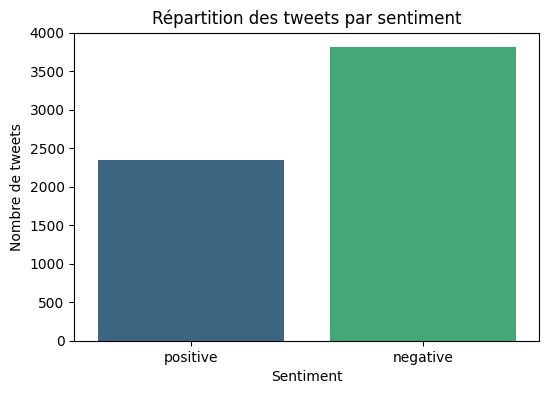

In [72]:
# 1. Chargement et nettoyage du fichier txt
df = pd.read_csv("SemEval.txt", sep="\t", header=None, names=["id", "sentiment", "tweet"])
df = df[df["sentiment"].isin(["positive", "negative"])].copy()
df.drop(columns=["id"], inplace=True)

# Affichage de la répartition des classes
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title("Répartition des tweets par sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de tweets")
plt.show()

In [73]:
# 2. Nettoyage léger du texte (FinBERT gère mieux le texte brut)
def clean_text_finbert(text):
    # Nettoyage minimal pour FinBERT
    text = re.sub(r"http\S+", "", text)  # URLs
    text = re.sub(r"@\w+", "@user", text)  # Mentions
    text = re.sub(r"#", "", text)  # Hashtags (garder le texte)
    return text.strip()

df["clean_tweet"] = df["tweet"].apply(clean_text_finbert)
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})

In [74]:
df.head()

,sentiment,tweet,clean_tweet,label
1,positive,Ariana Grande KIIS FM Yours Truly CD listening...,Ariana Grande KIIS FM Yours Truly CD listening...,1
2,positive,Ariana Grande White House Easter Egg Roll in W...,Ariana Grande White House Easter Egg Roll in W...,1
3,positive,#CD #Musics Ariana Grande Sweet Like Candy 3.4...,CD Musics Ariana Grande Sweet Like Candy 3.4 o...,1
5,positive,Hairspray Live! Previews at the Macy's Thanksg...,Hairspray Live! Previews at the Macy's Thanksg...,1
6,positive,#LindsayLohan Is ‘Feeling Thankful’ After Blas...,LindsayLohan Is ‘Feeling Thankful’ After Blast...,1


In [75]:
# 3. Préparation du Dataset pour FinBERT
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [76]:
# 4. Chargement du modèle FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)
model.to(device)

print(f"Modèle FinBERT chargé: {model_name}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle FinBERT chargé: ProsusAI/finbert


In [77]:
# 5. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_tweet"].values,
    df["label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["label"].values
)

# Créer les datasets
train_dataset = TweetDataset(X_train, y_train, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

print(f"Taille du jeu d'entraînement: {len(train_dataset)}")
print(f"Taille du jeu de test: {len(test_dataset)}")

Taille du jeu d'entraînement: 4930
Taille du jeu de test: 1233


In [78]:
# 6. Configuration de l'entraînement avec PyTorch natif

# Hyperparamètres
EPOCHS = 3
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Optimizer et Loss
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

print(f"Configuration:")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Nombre de batches d'entraînement: {len(train_loader)}")
print(f"- Nombre de batches de test: {len(test_loader)}")

Configuration:
- Epochs: 3
- Batch size: 8
- Learning rate: 2e-05
- Nombre de batches d'entraînement: 617
- Nombre de batches de test: 78


In [ ]:
# 7. Entraînement du modèle
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct/total})
    
    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), np.array(all_preds), np.array(all_labels)

# Entraînement
print("Début de l'entraînement...")
best_f1 = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_f1': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    # Entraînement
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Évaluation
    val_loss, val_preds, val_labels = evaluate(model, test_loader, criterion, device)
    val_f1 = f1_score(val_labels, val_preds)
    val_acc = accuracy_score(val_labels, val_preds)
    
    # Sauvegarder l'historique
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    print(f"\nRésultats Epoch {epoch + 1}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    
    # Sauvegarder le meilleur modèle
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), './tweets_finbert_sentiment_model/tweets_best_finbert_model.pt')
        print(f"✓ Meilleur modèle sauvegardé (F1: {best_f1:.4f})")

print("\n" + "="*50)
print("Entraînement terminé!")
print(f"Meilleur F1-score: {best_f1:.4f}")

Début de l'entraînement...

Epoch 1/3


Training:   3%|▎         | 20/617 [03:34<3:25:01, 20.61s/it, loss=0.568, acc=0.637]

In [ ]:
# 8. Évaluation du modèle
# Charger le meilleur modèle
model.load_state_dict(torch.load('./best_finbert_model.pt'))
model.eval()

# Prédictions finales
_, y_pred, y_true = evaluate(model, test_loader, criterion, device)

def evaluate_model(y_true, y_pred, title):
    print(f"\n--- Évaluation du modèle : {title} ---\n")
    print("Rapport de classification :\n")
    print(classification_report(y_true, y_pred, target_names=["Négatif", "Positif"]))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"\nRésumé:")
    print(f"Précision : {precision:.4f}")
    print(f"Rappel    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"Accuracy  : {accuracy:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", 
                xticklabels=["Négatif", "Positif"], 
                yticklabels=["Négatif", "Positif"])
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.title(f"Matrice de confusion : {title}")
    plt.show()

evaluate_model(y_true, y_pred, "FinBERT")

# Courbes d'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Évolution de la Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_f1'], label='Val F1-Score', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Évolution des métriques')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 10. Sauvegarder le modèle fine-tuné
model.save_pretrained("./finbert_sentiment_model")
tokenizer.save_pretrained("./finbert_sentiment_model")
print("Modèle sauvegardé dans ./finbert_sentiment_model")